# Problem 5.1
Attributions: Shashank did a,b, and c; Michelle did d; Elena did e; Elena and Shashank did f.

Before we do anything else, we load the necessary modules and read in the `DataFrame`.

In [3]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

#import stat tools
import numdifftools as ndt
import scipy.stats as st

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data
df = pd.read_csv('./data/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and take NaNs to be zero
df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)

# Part A
In the first part, we were asked to get the best unbiased estimate of the mean and variance. As discussed on multiple occasions during lecture and previous tutorials, we know that the sample mean is the best unbiased estimator of $\mu$. As far as the variance is concerned, the best unbiased estimator of variance is:

\begin{align}
⟨s^2⟩ = \frac{n}{n-1}\,\,s^2
\end{align}

We defined a function named `get_estimates` that takes a tidy dataset as an input, separates them on the basis of the two `genotypes`, and calculates the sample mean and variance (using the argument `ddof=1`). The function returns the mean and standard deviation of the two populations.

In [4]:
def get_estimates(data):
    """
    Takes a tody dataframe as an input. Returns:
    1. mu_wt
    2. mu_mut
    3. sigma_wt
    4. sigma_mut
    """
    #separate the dataset in to wild type and mutant
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]

    #find means for wt and mut
    mu_wt = wt_fish.mean()
    mu_mut = mut_fish.mean()

    #find unbiased estimator of variance for wt and mut
    sigma_wt = np.sqrt(wt_fish.var(ddof=1))
    sigma_mut = np.sqrt(mut_fish.var(ddof=1))

    #return values
    return float(mu_wt), float(mu_mut), float(sigma_wt), float(sigma_mut)

#part a

muWT, muMUT, sigmaWT, sigmaMUT = get_estimates(df)

print("""The best estimates for µ and σ are:
                µ           σ
             -----------------
    WT       {0:.4f}     {2:.4f}
    Mutant   {1:.4f}     {3:.4f}
    """.format(float(muWT), float(muMUT), 
           float(sigmaWT), float(sigmaMUT)))

The best estimates for µ and σ are:
                µ           σ
             -----------------
    WT       2.2094     0.5229
    Mutant   1.7271     0.8051
    


We defined another function called `cohen_d` to calculate the standardized difference between the two means (wildtype and mutant).

In [5]:
def cohen_d(data):
    """
    Cohen's d
    """
    #separate the dataset in to wild type and mutant
    w = data[data["genotype"]=="wt"]
    m = data[data["genotype"]=="mut"]
    
    w_s = w.var(ddof=1)
    m_s = m.var(ddof=1)
    
    sd = ((len(w)-1) * w_s + (len(m) - 1) * m_s) / (len(w) + len(m) - 2)
    
    diff = m.mean() - w.mean()

    cohen = np.abs(diff) / np.sqrt(sd)
    
    return float(cohen)

effect_size = cohen_d(df)

print ('Effect size = {0:.4f}'.format(effect_size))

Effect size = 0.6918


We see that the effect size is ~0.7. This means that the mean of the wild-type and the mutant population differs by 0.7 standard deviations. This seems to be a fairly large effector size, considering that it supports what we would have biologically expected from our experiment before we collected the data points. 

# Part B

In part b, we have been asked to calculate the frequentist estimate of the difference of the means. For the sake of simplicity, we represent the difference of the means using $\delta$, which is defined as:
\begin{align}
\delta \equiv \mu_{wt} - \mu_{mut}
\end{align}

In order to calculate a frequentist estimate $\delta$, we will define two gaussian distributions using the mean ($\mu_{wt} \,\,\text{and} \,\,\mu_{mut}$) and standard deviation ($\sigma_{wt} \,\,\text{and} \,\,\sigma_{mut}$) obtained in the previous step. Then, we will draw samples out of these distributions (the number of samples will be equal to the number of wild type (17) and mutant entries (22) in the original dataframe). For each set of sampling events, the function `difference_of_means` will return the difference of the means of the two drawn populations. To follow a frequentist approach to estimate $\delta$, we will repeat this 10000 times to get the frequentist estimate with a 95% confidence interval.

The frequentist estimate of the difference of the mean is:
      µ(wt)-µ(mut) = 0.4823 ± 0.4200 minutes


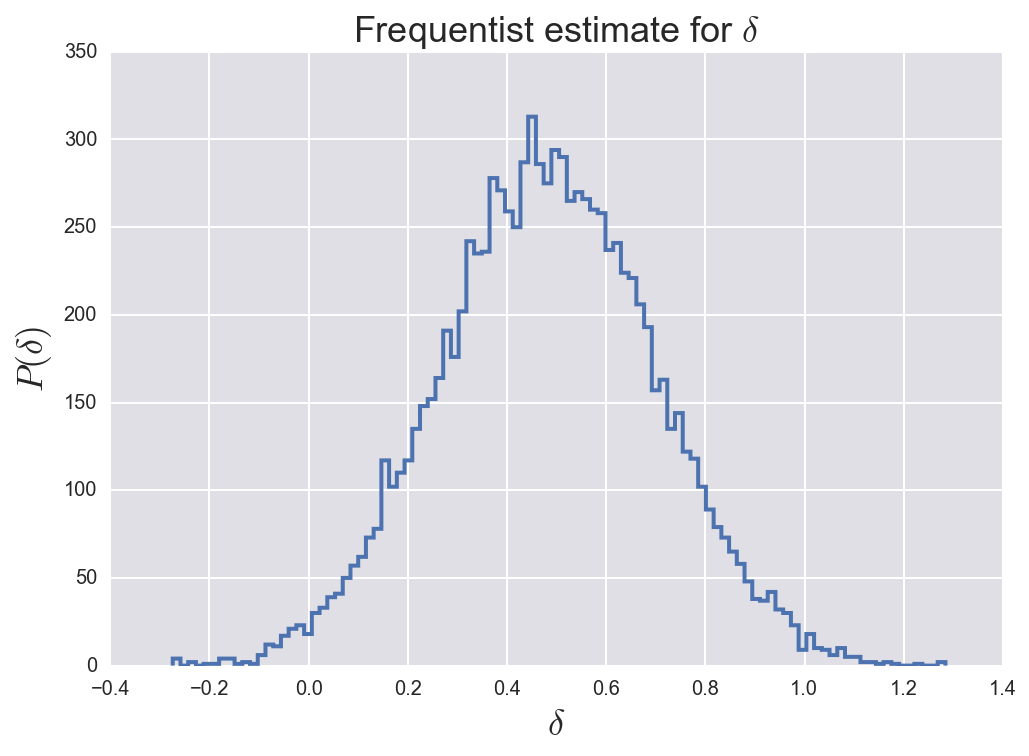

In [24]:
def get_frequentist_estimate(mu_wt, sigma_wt, mu_mut, sigma_mut, data, trials=10000):
    """
    Returns frequentist estimate of the difference of the mean with a 95%
    confidence interval. Takes as input the result of get_estimates 
    function defined in part a and the original tidy dataframe.
    """
   
    #separate the dataset in to wild type and mutant
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]
    
    def difference_of_means(mu_wt, sigma_wt, mu_mut, sigma_mut, reps_wt, reps_mut, trials):
        """
        This function draws samples out of a gaussian distribution defined for wildtype
        and mutant population using means and sigmas calculated in part a.
        """
        difference_mean_holder = np.empty(trials)
    
        for i in range(trials):
            wt_rep_mean = np.random.normal(mu_wt, sigma_wt, reps_wt).mean()
            mut_rep_mean = np.random.normal(mu_mut, sigma_mut, reps_mut).mean()
            difference_mean_holder[i] = wt_rep_mean - mut_rep_mean
        
        return difference_mean_holder
    
    difference_out = difference_of_means(muWT, 
                                         sigmaWT, 
                                         muMUT,
                                         sigmaMUT, 
                                         len(wt_fish),
                                         len(mut_fish), 
                                         trials)
    
    confidence_interval = 1.96*np.std(difference_out)
    frequentist_lowCI = float(mu_wt - mu_mut) - confidence_interval
    frequentist_highCI = float(mu_wt - mu_mut) + confidence_interval
    
    return float(mu_wt - mu_mut), confidence_interval, frequentist_lowCI, frequentist_highCI

def get_histogram(mu_wt, sigma_wt, mu_mut, sigma_mut, data, trials=10000):
    """
    Returns frequentist estimate of the difference of the mean with a 95%
    confidence interval. Takes as input the result of get_estimates 
    function defined in part a and the original tidy dataframe.
    """
   
    #separate the dataset in to wild type and mutant
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]
    
    def difference_of_means(mu_wt, sigma_wt, mu_mut, sigma_mut, reps_wt, reps_mut, trials):
        """
        This function draws samples out of a gaussian distribution defined for wildtype
        and mutant population using means and sigmas calculated in part a.
        """
        difference_mean_holder = np.empty(trials)
    
        for i in range(trials):
            wt_rep_mean = np.random.normal(mu_wt, sigma_wt, reps_wt).mean()
            mut_rep_mean = np.random.normal(mu_mut, sigma_mut, reps_mut).mean()
            difference_mean_holder[i] = wt_rep_mean - mut_rep_mean
        
        return difference_mean_holder
    
    difference_out = difference_of_means(muWT, 
                                         sigmaWT, 
                                         muMUT,
                                         sigmaMUT, 
                                         len(wt_fish),
                                         len(mut_fish), 
                                         trials)
    
    _ = plt.hist(difference_out, bins = 100, histtype = "step", lw=2)
    plt.title("Frequentist estimate for $\delta$")
    plt.ylabel("$P(\delta)$")
    plt.xlabel("$\delta$")
    
#unpack results
frequentist_estimate, confidence_interval, frequentist_lowCI, frequentist_highCI = \
get_frequentist_estimate(muWT, sigmaWT, muMUT, sigmaMUT, df, 10000)

print("""The frequentist estimate of the difference of the mean is:
      µ(wt)-µ(mut) = {0:.4f} ± {1:.4f}"""
      .format(float(frequentist_estimate), confidence_interval), "minutes")
#get histogram

get_histogram(muWT, sigmaWT, muMUT, sigmaMUT, df, 10000)

As can be seen above, $\delta$ = 0.4823 minutes, with a 95% confidence interval of 0.4200 minutes. A confidence interval that big might seem odd at first. However, this is because we do not have a lot of data points to begin with, in the absence of which, the confidence interval, by definition, is stretched to include all possible values around the actual difference. It is important to note that a 95% confidence interval in frequentist statistics is defined as the region that will contain 95% of the values generated by doing the "experiment" over and over again (in this case, multiple draws).
The y-axis in the histogram represents a frequentist probability. This is a probability distribution describing the values that we would estimate for $\delta$ if we did the experiment over and over and over again. 

# Part C

For part c, we were asked to get a bayesian estimate for $\delta$.
The posterior distribution for estimating the parameters ($\mu_{wt}, \mu_{mut}, \sigma_{wt}, \sigma_{mut}$) from a gaussian distribution was defined as:
\begin{align}
P(\mu_{wt}, \sigma_{wt} \mid {x_i},I) \propto \frac{1}{\sigma_{wt}^{n+1}}\,\, \exp \Bigg[ \sum\limits_{i \in D} \frac {(\mu_{wt} - x_i)^2}{2\sigma_{wt}^2} \Bigg] &&\text{and} \\
P(\mu_{mut}, \sigma_{mut} \mid {x_i},I) \propto \frac{1}{\sigma_{mut}^{n+1}}\,\, \exp \Bigg[ \sum\limits_{i \in D} \frac { (\mu_{mut} - x_i)^2}{2\sigma_{mut}^2} \Bigg]
\end{align}

We used `scipy.stats.norm.logpdf` to calculate the log posterior distribution for the combination of the two. Since we were not doing regression analysis, we decided to use the `scipy.optimize.minimize` method to find the MAP and the covariance matrix.

In [8]:
def get_bayesian_estimate(data):
    """
    This function takes the dataframe containing wildtype and mutant fish and
    calculates the bayesian estimate for the difference of the means.
    """
    #separate the dataset in to wild type and mutant
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]
    
    # Define log of the posterior
    def log_post(p, x_wt, x_mut):
        """
        Returns the log of the posterior consisting of the product of Gaussians.
        p[0] = mu_wt
        p[1] = mu_mut
        p[2] = sigma_wt
        p[3] = sigma_mut
        """
        # Unpack parameters
        mu_wt, mu_mut, sigma_wt, sigma_mut = p
    
        # Make sure we have everything in the right range
        if (sigma_wt < 0) or (sigma_mut < 0):
            return -np.inf

        # Compute separate parts of posterior from each sample
        log_post_wt = st.norm.logpdf(x_wt, mu_wt, sigma_wt).sum() - np.log(sigma_wt)
    
        log_post_mut = st.norm.logpdf(x_mut, mu_mut, sigma_mut).sum() - np.log(sigma_mut)

        # Add them up to return
        return log_post_wt + log_post_mut

    def negative_log_post(p, x_wt, x_mut):
        
        return -log_post(p, x_wt, x_mut)

    #MAP
    wt = wt_fish[("mean_rest_bout_length")]
    mut = mut_fish[("mean_rest_bout_length")]
    
    #define args
    args = (wt, mut)
    p0 = np.array([ 2, 1.5, 0.5, 0.8])

    #calculate hessian matrix
    hes_fun = ndt.Hessian(log_post)
    res = scipy.optimize.minimize(negative_log_post, p0, args=args)
    hes = hes_fun(res.x,wt,mut)
    cov = -np.linalg.inv(hes)

    #estimate delta
    bayesian_estimate_diff = res.x[0] - res.x[1]
    credible_interval = 1.96 * np.sqrt(np.sqrt(cov[0,0])**2 + np.sqrt(cov[1,1])**2)
    
    #report low and high credible region
    lowCI = bayesian_estimate_diff - credible_interval
    highCI = bayesian_estimate_diff + credible_interval
    
    return float(bayesian_estimate_diff), float(credible_interval), cov, float(res.x[0]), float(res.x[1]), \
float(res.x[2]), float(res.x[3]), float(lowCI), float(highCI)

bayesian_estimate, credible_interval, covariance, WTmuMAP, MUTmuMAP, WTsigmaMAP, MUTsigmaMAP, \
bayesian_lowCI, bayesian_highCI = get_bayesian_estimate(df)

print("""The Bayesian estimate of the difference of the mean is:
    µ(wt)-µ(mut) = {0:.4f} ± {1:.4f}""".format(bayesian_estimate, credible_interval), "minutes.")

The Bayesian estimate of the difference of the mean is:
    µ(wt)-µ(mut) = 0.4823 ± 0.3978 minutes.


The bayesian estimate for $\delta$ is the same as the frequentist estimate. However, the 95% credible region calculated using the bayesian method is 0.3978 minutes. This is slightly lower than the frequentist estimate. The credible region defines a range within which 95% of the values are contained.

# Part D

Our null hypothesis, $H_0$ is that the wild type and mutant are drawn from the same Gaussian distribution. In other words, the mean of the two populations is the same.
\begin{align}
H_0 : \mu_{wt} = \mu_{mut} \\
H_A : \mu_{wt} ≠ \mu_{mut}
\end{align}

In order to test our null hypothesis. 

We can use a T-statistic as our measurable statistic. 
\begin{align}
T = \frac {\bar{x}_1 - \bar{x}_2 - n_1 + n_2} {S_D \sqrt{n^{-1}_1 + n^{-1}_2}}
\end{align}
Where $S_D$ is defined as:
\begin{align}
S_D = \frac {(n_1 - 1)S_1^2 + (n_2 - 1)S_2^2} {n_1 + n_2 -2}
\end{align}
And $S_1$ and $S_2$ are
\begin{align}
S = \frac {1}{n - 1} \sum_{i \in D}{(x_i - \bar{x})^2}
\end{align}
for their respective values.

We want to combine all of our measurements and then redistribute them to a group of 17 and group of 22 and we want to do this over and over again. 

In [10]:
# our null hypothesis is that the mutant and the wild type are drawn from the same
# Gaussian distribution in other words we want to test if the mutant mean is the same
# as the wt mean

# We first combine all of the measurements and then distrbute them to a set of 17 and 
# a set of 22

def final_p_value(data, trials=10000, greater_or_less='greater', return_abs=False):
    
    #separate the dataset in to wild type and mutant
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]
    
    # we want to make an array of the mean rest bout lengths
    w = wt_fish['mean_rest_bout_length'].values
    m = mut_fish['mean_rest_bout_length'].values
    
    def distribute_samples(w, m, some_func, trials, args=()):
        '''
        combine our measurements for rest bout and redistribute them to two groups
        '''
    
        # first we create an empty array to store our samples
        samples = np.empty(trials)
    
        # concatenate all the measurements
        measurements = np.concatenate((w, m))
    
        # create sets for all trials 
        for i in range(trials):
            measurements = np.random.permutation(measurements)
            samples[i] = some_func(measurements[:len(w)], measurements[len(w):], *args)
     
        return samples


    # now I want to define the p-value
    def p_value(samples, actual, greater_or_less='greater'):
        '''
        compute the p value (the probability our measurement is 
        greather than or less than the actual value
        '''
    
        if greater_or_less == 'greater':
            return float(np.sum(samples >= actual) / len(samples))
        else:
            return float(np.sum(samples <= actual) / len(samples))

    # now we can run our test and see if we will get the actual difference in our means
    # this will be my some_func in my distribute_samples function
    
    def T_stat(w, m, return_abs=False):
        '''
        Calculate the absolute difference of the means
        '''
        w_s = w.var(ddof=1)
        m_s = m.var(ddof=1)
    
        sd = ((len(w)-1) * w_s**2 + (len(m) - 1) * m_s**2) / (len(w) + len(m) - 2)
    
        diff = w.mean() - m.mean() - np.sqrt(w.var()) + np.sqrt(m.var()) 
        pool_variance = sd * np.sqrt(1/(len(w)) + 1/(len(m)))
            
        if return_abs:
            return float(np.abs(diff) / pool_variance  )
        return float(diff / pool_variance)


    # let's retrieve all our random sample sets of two
    samples = distribute_samples(w, m, T_stat, trials, args = (True,))

    # calculate p value
    p_value_student_t = p_value(samples, T_stat(w, m))

    return float(p_value_student_t)

p_value = final_p_value(df, 10000)

print("Student's t test p value =", p_value)

Student's t test p value = 0.0206


# Part E

In [11]:
def odds_ratio(data, cov, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map):
    """
    This function calculates the odds ratio for H_0 and H_1.
    
    data = the dataframe with all of the wt and mut fish
    cov = the covariance matrix calculated for the joint Gaussian distribution in part (c)
    wt_mu_map = the MAP for the wild-type mu as calculated in part (c)
    wt_sigma_map = the MAP for the wild-type sigma as calculated in part (c)
    mut_mu_map = the MAP for the mutant mu as calculated in part (c)
    mut_sigma_map = the MAP for the mutant sigma as calculated in part (c)
    
    """
    # Set up additional variables to pass in as arguments to the sub-functions
    wt_fish = data[data['genotype']=='wt']
    mut_fish = data[data['genotype']=='mut']
    
    p = np.asarray([data['mean_rest_bout_length'].mean(), data['mean_rest_bout_length'].std()])
    x = data['mean_rest_bout_length']
    wt_mut = np.asarray([wt_fish['mean_rest_bout_length'], mut_fish['mean_rest_bout_length']])
    
    # Define log of the posterior for H_0 
    def log_post_H0(p, x):
        """
        Returns the log of the posterior for a Gaussian.
        p[0] = mu
        p[1] = sigma
        """
        # Unpack parameters
        mu, sigma = p
    
        # Make sure we have everything in the right range
        if (sigma < 0):
            return -np.inf

        # Add them up to return
        output = float(st.norm.logpdf(x, mu, sigma).sum() - np.log(sigma))
                
        return output

    def cov_H0(p, x):    
        """
        Calculates the covariance matrix for H_0
        """
        # Instantiate Hessian for log posterior for H_0
        hes_fun = ndt.Hessian(log_post_H0)

        # Compute Hessian at MAP for H_0
        hes = hes_fun(p, x)
        cov = -np.linalg.inv(hes)
            
        return cov

    def log_good_fit_ratio(p, x, wt_mut, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map): 
        """
        Calculates the log of the goodness of fit ratio
        """
        # Unpack parameters
        mu, sigma = p
        
        ratio_output = st.norm.logpdf(x, mu, sigma).sum() \
    - st.norm.logpdf(wt_mut[0], wt_mu_map, wt_sigma_map).sum() \
    - st.norm.logpdf(wt_mut[1], mut_mu_map, mut_sigma_map).sum()
        
        return float(ratio_output)

    def log_occam(p, x, wt_sigma_map, mut_sigma_map, cov):
        """
        Calculates the log of the Occam factor
        """
        # Unpack parameters
        mu, sigma = p
                
        return np.log(wt_sigma_map) + np.log(mut_sigma_map) + \
                    np.log(2 * np.pi) + np.log(np.linalg.det(cov_H0(p, x)))/2 \
                    - np.log(sigma) - 2 * np.log(2 * np.pi) - np.log(np.linalg.det(cov))/2
      
    return float(np.exp(log_good_fit_ratio(p, x, wt_mut, wt_mu_map, wt_sigma_map, \
                                     mut_mu_map, mut_sigma_map) \
                  + log_occam(p, x, wt_sigma_map, mut_sigma_map, cov)))

o_r = odds_ratio(df, covariance, WTmuMAP, WTsigmaMAP, MUTmuMAP, MUTsigmaMAP)
print("""Odds ratio = {0:.4f}""".format(o_r))

Odds ratio = 0.0830


# Part F

In [12]:
def sample_data(data):
    
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]

    def new_gaussian_draw(mu, std, s):
        """
        draw a sample of size s from a Gaussian distribution with mu = mu and 
        sigma = std
        """
        return np.random.normal(mu, std, s)

    new_wt_fish = wt_fish.drop('mean_rest_bout_length', axis=1)
    new_wt_fish['mean_rest_bout_length'] = new_gaussian_draw(muWT, sigmaWT, 17)
    new_mut_fish = mut_fish.drop('mean_rest_bout_length', axis=1)
    new_mut_fish['mean_rest_bout_length'] = new_gaussian_draw(muMUT, sigmaMUT, 22)
    new_fish = pd.concat((new_wt_fish, new_mut_fish), axis=0)
    
    return new_fish

#pseudo_confidence_interval_ar = np.empty(100)
pseudo_frequentist_estimate_ar = np.empty(100)
pseudo_frequentist_lowCI_ar = np.empty(100)
pseudo_frequentist_highCI_ar = np.empty(100)
#pseudo_credible_interval_ar = np.empty(100)
pseudo_bayesian_estimate_ar = np.empty(100)
pseudo_bayesian_lowCI_ar = np.empty(100)
pseudo_bayesian_highCI_ar = np.empty(100)
pseudo_p_value_ar = np.empty(100)
pseudo_odds_ratio_ar = np.empty(100)

for i in range(100):
    
    #sample data 
    pseudo_fish_data = sample_data(df)
        
    #get estimates from part a
    pseudo_muWT, pseudo_muMUT, pseudo_sigmaWT, pseudo_sigmaMUT = \
                                                get_estimates(pseudo_fish_data)
    
    #get frequentist estimate from part b
    pseudo_frequentist_estimate, pseudo_confidence_interval, \
    pseudo_frequentist_lowCI, pseudo_frequentist_highCI = \
    get_frequentist_estimate(pseudo_muWT, pseudo_sigmaWT, 
                             pseudo_muMUT, pseudo_sigmaMUT, 
                             pseudo_fish_data)
        
    #get bayesian estimate from part c
    pseudo_bayesian_estimate, pseudo_credible_interval, \
    pseudo_covariance, pseudo_WTmuMAP, pseudo_MUTmuMAP, pseudo_WTsigmaMAP, \
    pseudo_MUTsigmaMAP, pseudo_bayesian_lowCI, pseudo_bayesian_highCI  = \
    get_bayesian_estimate(pseudo_fish_data)
        
    #get p-value from part d
    pseudo_p_value = final_p_value(pseudo_fish_data, 10000)
    
    #get odd ratios from part e
    pseudo_odds_ratio = odds_ratio(pseudo_fish_data,
                                   pseudo_covariance,
                                   pseudo_WTmuMAP,
                                   pseudo_WTsigmaMAP,
                                   pseudo_MUTmuMAP,
                                   pseudo_MUTsigmaMAP)
        
    #store all values in arrays
    pseudo_frequentist_estimate_ar[i], pseudo_frequentist_lowCI_ar[i], \
    pseudo_frequentist_highCI_ar[i], pseudo_bayesian_estimate_ar[i], \
    pseudo_bayesian_lowCI_ar[i], pseudo_bayesian_highCI_ar[i], \
    pseudo_p_value_ar[i], pseudo_odds_ratio_ar[i] = pseudo_frequentist_estimate, \
    pseudo_frequentist_lowCI, pseudo_frequentist_highCI, \
    pseudo_bayesian_estimate, pseudo_bayesian_lowCI, \
    pseudo_bayesian_highCI, pseudo_p_value, pseudo_odds_ratio 

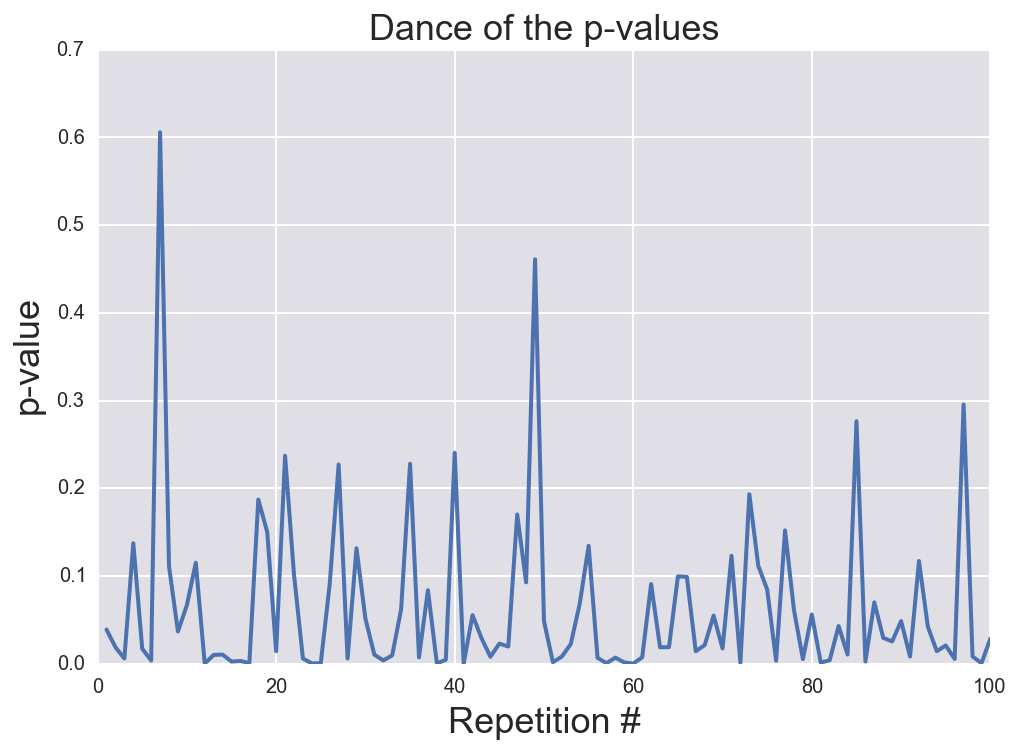

In [13]:
x=np.arange(1,101)
plt.plot(x,pseudo_p_value_ar[x-1])
plt.title("Dance of the p-values")
plt.xlabel("Repetition #")
plt.ylabel("p-value")

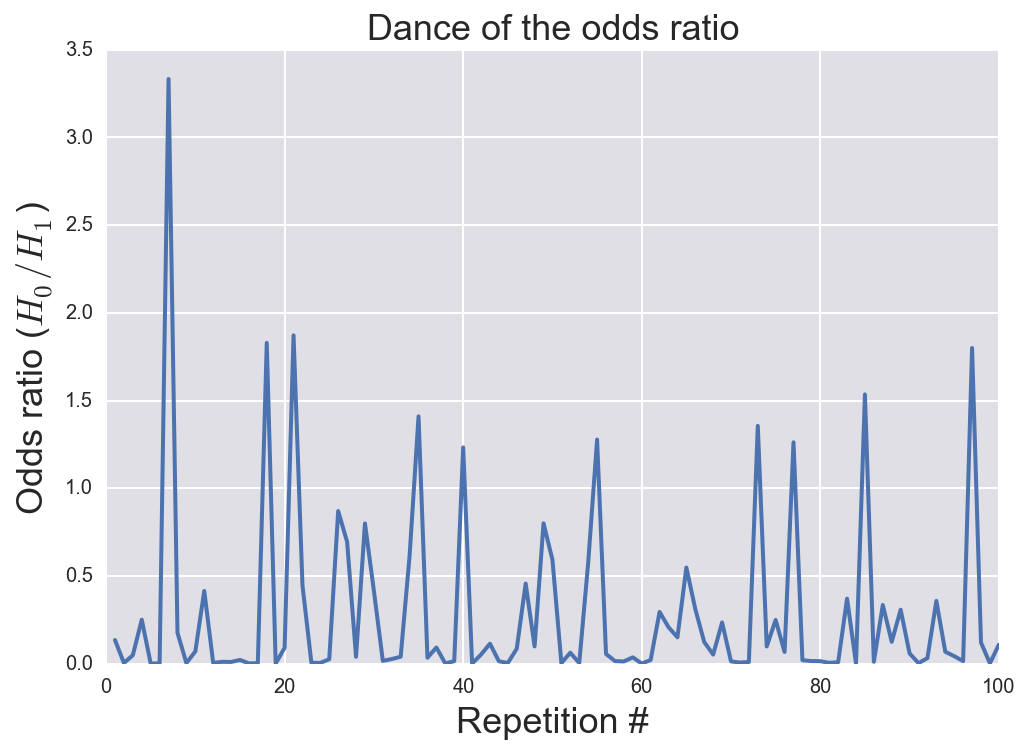

In [20]:
plt.plot(x,pseudo_odds_ratio_ar[x-1])
plt.title("Dance of the odds ratio")
plt.xlabel("Repetition #")
plt.ylabel("Odds ratio ($H_0/H_1$)")

$\delta \equiv \mu_{wt}-\mu_{mut}$

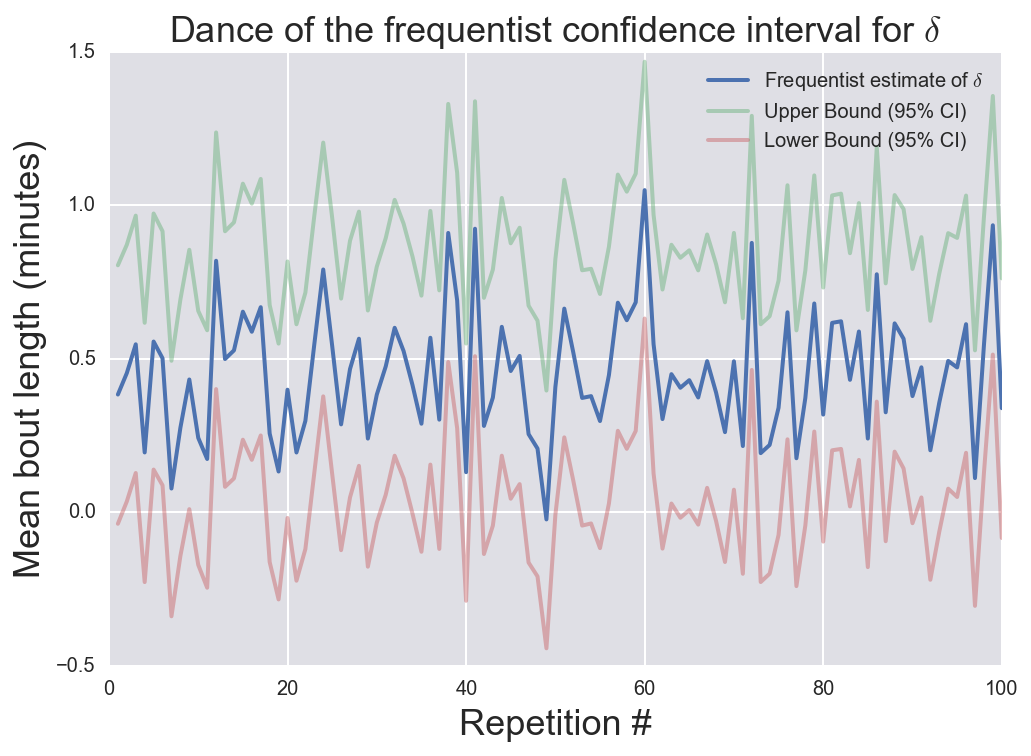

In [14]:
plt.plot(x,pseudo_frequentist_estimate_ar[x-1])
plt.plot(x,pseudo_frequentist_highCI_ar[x-1],alpha=0.4)
plt.plot(x,pseudo_frequentist_lowCI_ar[x-1],alpha=0.4)
plt.title("Dance of the frequentist confidence interval for $\delta$")
plt.xlabel("Repetition #")
plt.ylabel("Mean bout length (minutes)")
plt.legend(labels=["Frequentist estimate of $\delta$", "Upper Bound (95% CI)", "Lower Bound (95% CI)",])

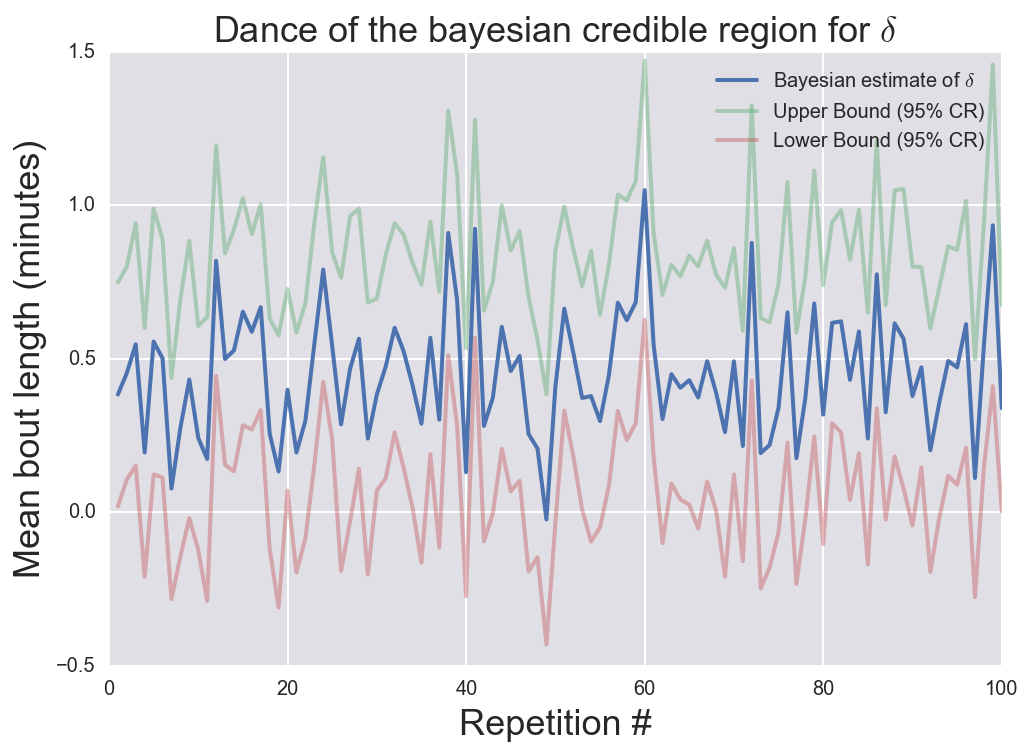

In [15]:
plt.plot(x,pseudo_bayesian_estimate_ar[x-1])
plt.plot(x,pseudo_bayesian_highCI_ar[x-1],alpha=0.4)
plt.plot(x,pseudo_bayesian_lowCI_ar[x-1],alpha=0.4)
plt.title("Dance of the bayesian credible region for $\delta$")
plt.xlabel("Repetition #")
plt.ylabel("Mean bout length (minutes)")
plt.legend(labels=["Bayesian estimate of $\delta$", "Upper Bound (95% CR)", "Lower Bound (95% CR)",])

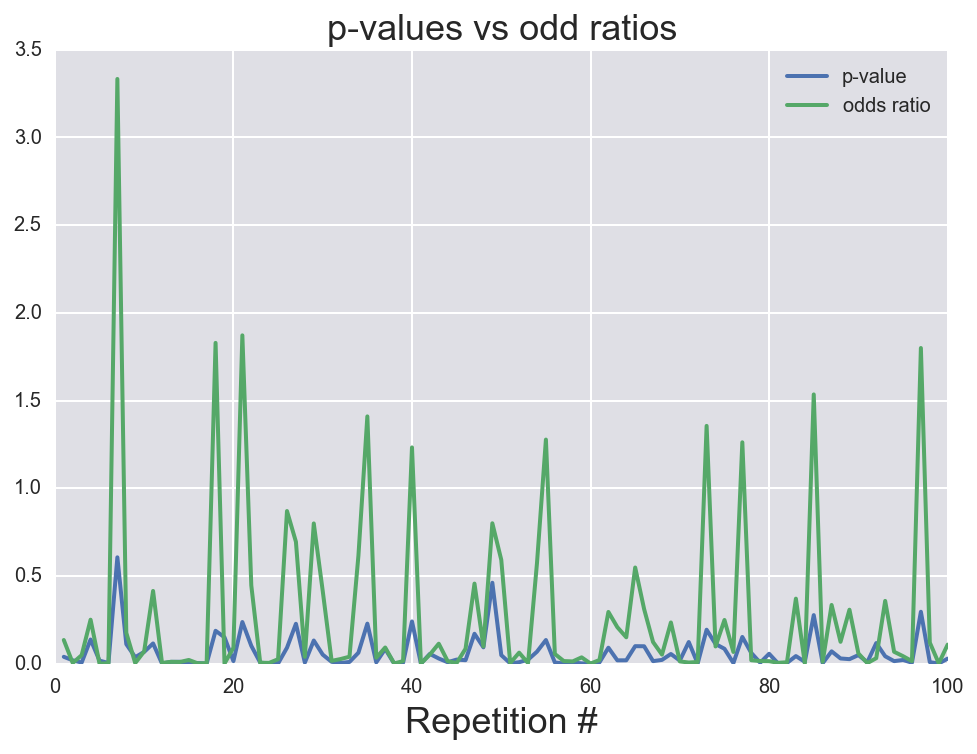

In [21]:
plt.plot(x,pseudo_p_value_ar[x-1])
plt.plot(x,pseudo_odds_ratio_ar[x-1])
plt.title("p-values vs odd ratios")
plt.xlabel("Repetition #")
plt.legend(labels = ["p-value","odds ratio"])
#plt.ylabel("p-value")

There seems to be a correlation between the p-value and the odds ratio, i.e., the odds ratio seems to fluctuate in resonance with the p-value. This might explain why people conflate the p-value with the probability of the null-hypothesis.